<b>Google Colab</b> <a href="https://colab.research.google.com/github/kirillzyusko/stock-predictions/blob/master/lab.ipynb">link</a>

In [41]:
import pandas as pd

train = pd.read_csv('https://raw.githubusercontent.com/kirillzyusko/stock-predictions/master/train.csv')
store = pd.read_csv('https://raw.githubusercontent.com/kirillzyusko/stock-predictions/master/store.csv')

def one_hot(dataframe, column):
    # use pd.concat to join the new columns with your original dataframe
    df = pd.concat([dataframe, pd.get_dummies(dataframe[column], prefix=column)], axis=1)
    # now drop the original column (you don't need it anymore)
    df.drop([column], axis=1, inplace=True)

    return df

def inner_join(df1, df2, column):
    return pd.concat([df1.set_index(column),df2.set_index(column)], axis=1, join='inner').reset_index()

def where_equal(df, column, value):
    return df[df[column] == value]

def get_data():
    df = one_hot(train, 'DayOfWeek')

    df = inner_join(df, store, 'Store')
    df = one_hot(df, 'StoreType')
    df = one_hot(df, 'Assortment')
    #df = one_hot(df, 'Store')

    df.drop([
        'StateHoliday',
        'SchoolHoliday',
        'Date',
        'Customers',
        'Promo',
        'PromoInterval',
        'Promo2',
        'Promo2SinceWeek',
        'Promo2SinceYear',
        'CompetitionDistance',
        'CompetitionOpenSinceMonth',
        'CompetitionOpenSinceYear'
    ], axis=1, inplace=True)

    # data = where_equal(df, 'Store', 1)
    # print(list(df))
    print(df.head())

    return df

get_data()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


   Store  Sales  Open  ...  Assortment_a  Assortment_b  Assortment_c
0      1   5263     1  ...             1             0             0
1      2   6064     1  ...             1             0             0
2      3   8314     1  ...             1             0             0
3      4  13995     1  ...             0             0             1
4      5   4822     1  ...             1             0             0

[5 rows x 17 columns]


,Store,Sales,Open,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c
0,1,5263,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0
1,2,6064,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0
2,3,8314,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0
3,4,13995,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1
4,5,4822,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0
1017205,1112,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
1017206,1113,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
1017207,1114,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1


In [47]:
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from keras.layers import Dropout
from sklearn.model_selection import train_test_split

import tensorflow as tf

data = get_data()
data = data[data['Store'] == 1]

y = data['Sales']
data.drop(['Sales'], axis=1, inplace=True)
X = data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

length, features = data.shape
stocks = 1115

model = Sequential()
model.add(Dense(int(features * 1.5), input_dim=features, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.001), activation='relu', name='hidden_1'))
#model.add(Dropout(0.4, name='dropout_1'))
model.add(Dense(features, kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.l2(0.001), name='hidden_2'))
#model.add(Dropout(0.4, name='dropout_2'))
model.add(Dense(int(features * 0.5), kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.l2(0.001), name='hidden_3'))
#model.add(Dropout(0.5, name='dropout_3'))
model.add(Dense(1, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.01), name='output_layer'))

# Compile model
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

print(model.summary())

model.fit(X_train, y_train,
          epochs=50000,
          validation_data=(X_test, y_test),
          verbose=0)

score = model.evaluate(X_test, y_test, verbose=0)
print(score)

   Store  Sales  Open  ...  Assortment_a  Assortment_b  Assortment_c
0      1   5263     1  ...             1             0             0
1      2   6064     1  ...             1             0             0
2      3   8314     1  ...             1             0             0
3      4  13995     1  ...             0             0             1
4      5   4822     1  ...             1             0             0

[5 rows x 17 columns]
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_1 (Dense)             (None, 24)                408       
_________________________________________________________________
hidden_2 (Dense)             (None, 16)                400       
_________________________________________________________________
hidden_3 (Dense)             (None, 8)                 136       
_________________________________________________________________
output_layer

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


942


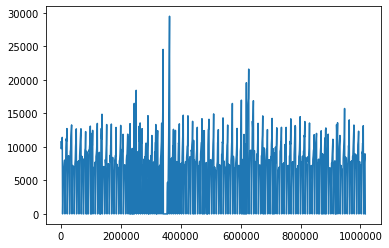

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('https://raw.githubusercontent.com/kirillzyusko/stock-predictions/master/train.csv')
data = df[df['Store'] == 123]['Sales']

print(len(data))

plt.plot(data)
plt.show()